# Paths

In [ ]:
dataset_path = "../datasets/SimpleSoyBean"
tensorboard_path = "../logs/"
models_path = "../models/SoyBean/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [ ]:
# transformações para a ResNet50
from torchvision.models import ResNet50_Weights
my_transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

In [ ]:
import torch
import torchvision

# carrega o dataset de imagens com as transformações definidas
data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

# divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 512

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

1167
816
351


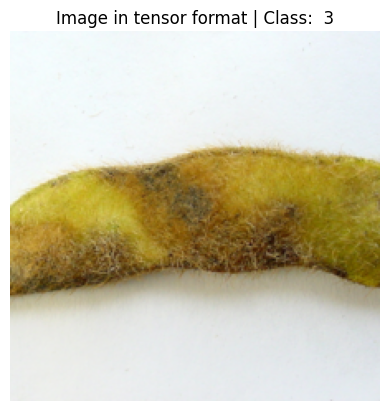

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

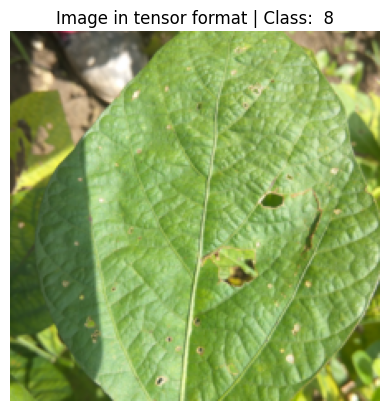

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [ ]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    # otimizador e função de perda
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break


    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # loss
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # backpropagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # accuracy
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "SoyBean"
        path = f'{models_path}ResNet50-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [ ]:
# função de validação do modelo
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [10]:
import torch
from torchvision.models import resnet50

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet50-SoyNet-96.53.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
# congela as camadas do modelo
for param in modelResNetTL.parameters():
    param.requires_grad = False

# habilita o treinamento da camada final - Transfer Learning
modelResNetTL.fc.requires_grad_(True)

# define o número de classes do dataset SoyBean
num_classes = 13
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [ ]:
# verifica as camadas que estão congeladas
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

Running on cuda
Labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


Training epochs...:   1%|          | 1/100 [01:44<2:52:44, 104.69s/it]

Saving Best Model with Accuracy:  8.262108262108262
Epoch:   1 | Accuracy :  8.2621%


Training epochs...:   2%|▏         | 2/100 [03:20<2:42:43, 99.63s/it] 

Saving Best Model with Accuracy:  12.535612535612536
Epoch:   2 | Accuracy : 12.5356%


Training epochs...:   3%|▎         | 3/100 [04:46<2:31:01, 93.41s/it]

Saving Best Model with Accuracy:  16.23931623931624
Epoch:   3 | Accuracy : 16.2393%


Training epochs...:   4%|▍         | 4/100 [06:16<2:27:12, 92.01s/it]

Saving Best Model with Accuracy:  20.22792022792023
Epoch:   4 | Accuracy : 20.2279%


Training epochs...:   5%|▌         | 5/100 [07:46<2:24:19, 91.15s/it]

Saving Best Model with Accuracy:  24.501424501424502
Epoch:   5 | Accuracy : 24.5014%


Training epochs...:   6%|▌         | 6/100 [09:11<2:19:29, 89.03s/it]

Saving Best Model with Accuracy:  30.1994301994302
Epoch:   6 | Accuracy : 30.1994%


Training epochs...:   7%|▋         | 7/100 [10:32<2:14:09, 86.56s/it]

Saving Best Model with Accuracy:  36.75213675213675
Epoch:   7 | Accuracy : 36.7521%


Training epochs...:   8%|▊         | 8/100 [11:52<2:09:39, 84.56s/it]

Saving Best Model with Accuracy:  42.73504273504273
Epoch:   8 | Accuracy : 42.7350%


Training epochs...:   9%|▉         | 9/100 [13:15<2:07:20, 83.96s/it]

Saving Best Model with Accuracy:  47.293447293447294
Epoch:   9 | Accuracy : 47.2934%


Training epochs...:  10%|█         | 10/100 [14:37<2:04:46, 83.18s/it]

Saving Best Model with Accuracy:  51.851851851851855
Epoch:  10 | Accuracy : 51.8519%


Training epochs...:  11%|█         | 11/100 [15:59<2:03:11, 83.05s/it]

Saving Best Model with Accuracy:  56.41025641025641
Epoch:  11 | Accuracy : 56.4103%


Training epochs...:  12%|█▏        | 12/100 [17:20<2:00:53, 82.43s/it]

Saving Best Model with Accuracy:  58.11965811965812
Epoch:  12 | Accuracy : 58.1197%


Training epochs...:  13%|█▎        | 13/100 [18:49<2:02:04, 84.19s/it]

Saving Best Model with Accuracy:  58.97435897435897
Epoch:  13 | Accuracy : 58.9744%


Training epochs...:  14%|█▍        | 14/100 [20:19<2:03:17, 86.01s/it]

Saving Best Model with Accuracy:  59.25925925925926
Epoch:  14 | Accuracy : 59.2593%


Training epochs...:  15%|█▌        | 15/100 [21:50<2:04:04, 87.58s/it]

Saving Best Model with Accuracy:  60.3988603988604
Epoch:  15 | Accuracy : 60.3989%


Training epochs...:  16%|█▌        | 16/100 [23:20<2:03:45, 88.40s/it]

Saving Best Model with Accuracy:  62.10826210826211
Epoch:  16 | Accuracy : 62.1083%


Training epochs...:  17%|█▋        | 17/100 [24:50<2:02:55, 88.86s/it]

Saving Best Model with Accuracy:  62.67806267806268
Epoch:  17 | Accuracy : 62.6781%


Training epochs...:  18%|█▊        | 18/100 [26:20<2:01:51, 89.17s/it]

Saving Best Model with Accuracy:  63.81766381766382
Epoch:  18 | Accuracy : 63.8177%


Training epochs...:  19%|█▉        | 19/100 [27:50<2:00:30, 89.27s/it]

Saving Best Model with Accuracy:  64.95726495726495
Epoch:  19 | Accuracy : 64.9573%


Training epochs...:  20%|██        | 20/100 [29:21<1:59:56, 89.96s/it]

Saving Best Model with Accuracy:  66.0968660968661
Epoch:  20 | Accuracy : 66.0969%


Training epochs...:  21%|██        | 21/100 [30:52<1:58:38, 90.10s/it]

Epoch:  21 | Accuracy : 65.8120%


Training epochs...:  22%|██▏       | 22/100 [32:22<1:57:08, 90.11s/it]

Saving Best Model with Accuracy:  66.38176638176638
Epoch:  22 | Accuracy : 66.3818%


Training epochs...:  23%|██▎       | 23/100 [33:52<1:55:43, 90.18s/it]

Saving Best Model with Accuracy:  67.23646723646723
Epoch:  23 | Accuracy : 67.2365%


Training epochs...:  24%|██▍       | 24/100 [35:23<1:54:24, 90.32s/it]

Saving Best Model with Accuracy:  67.52136752136752
Epoch:  24 | Accuracy : 67.5214%


Training epochs...:  25%|██▌       | 25/100 [36:52<1:52:27, 89.97s/it]

Saving Best Model with Accuracy:  67.80626780626781
Epoch:  25 | Accuracy : 67.8063%


Training epochs...:  26%|██▌       | 26/100 [38:22<1:50:53, 89.91s/it]

Saving Best Model with Accuracy:  68.37606837606837
Epoch:  26 | Accuracy : 68.3761%


Training epochs...:  27%|██▋       | 27/100 [39:52<1:49:38, 90.11s/it]

Saving Best Model with Accuracy:  68.66096866096866
Epoch:  27 | Accuracy : 68.6610%


Training epochs...:  28%|██▊       | 28/100 [41:22<1:48:07, 90.11s/it]

Saving Best Model with Accuracy:  69.51566951566952
Epoch:  28 | Accuracy : 69.5157%


Training epochs...:  29%|██▉       | 29/100 [42:52<1:46:34, 90.07s/it]

Saving Best Model with Accuracy:  70.37037037037037
Epoch:  29 | Accuracy : 70.3704%


Training epochs...:  30%|███       | 30/100 [44:21<1:44:29, 89.57s/it]

Saving Best Model with Accuracy:  70.94017094017094
Epoch:  30 | Accuracy : 70.9402%


Training epochs...:  31%|███       | 31/100 [45:51<1:43:14, 89.78s/it]

Saving Best Model with Accuracy:  71.22507122507122
Epoch:  31 | Accuracy : 71.2251%


Training epochs...:  32%|███▏      | 32/100 [47:22<1:42:01, 90.02s/it]

Saving Best Model with Accuracy:  71.5099715099715
Epoch:  32 | Accuracy : 71.5100%


Training epochs...:  33%|███▎      | 33/100 [48:49<1:39:48, 89.38s/it]

Saving Best Model with Accuracy:  72.36467236467236
Epoch:  33 | Accuracy : 72.3647%


Training epochs...:  34%|███▍      | 34/100 [50:14<1:36:48, 88.00s/it]

Saving Best Model with Accuracy:  72.93447293447294
Epoch:  34 | Accuracy : 72.9345%


Training epochs...:  35%|███▌      | 35/100 [51:40<1:34:35, 87.32s/it]

Saving Best Model with Accuracy:  73.5042735042735
Epoch:  35 | Accuracy : 73.5043%


Training epochs...:  36%|███▌      | 36/100 [53:05<1:32:28, 86.70s/it]

Epoch:  36 | Accuracy : 73.2194%


Training epochs...:  37%|███▋      | 37/100 [54:30<1:30:18, 86.01s/it]

Epoch:  37 | Accuracy : 73.5043%


Training epochs...:  38%|███▊      | 38/100 [55:53<1:27:56, 85.10s/it]

Epoch:  38 | Accuracy : 72.9345%


Training epochs...:  39%|███▉      | 39/100 [57:17<1:26:21, 84.94s/it]

Saving Best Model with Accuracy:  73.78917378917379
Epoch:  39 | Accuracy : 73.7892%


Training epochs...:  40%|████      | 40/100 [58:48<1:26:51, 86.86s/it]

Epoch:  40 | Accuracy : 73.5043%


Training epochs...:  41%|████      | 41/100 [1:00:19<1:26:31, 87.99s/it]

Saving Best Model with Accuracy:  74.35897435897436
Epoch:  41 | Accuracy : 74.3590%


Training epochs...:  42%|████▏     | 42/100 [1:01:50<1:26:01, 88.99s/it]

Saving Best Model with Accuracy:  74.64387464387464
Epoch:  42 | Accuracy : 74.6439%


Training epochs...:  43%|████▎     | 43/100 [1:03:22<1:25:14, 89.73s/it]

Epoch:  43 | Accuracy : 74.6439%


Training epochs...:  44%|████▍     | 44/100 [1:04:53<1:24:13, 90.24s/it]

Saving Best Model with Accuracy:  75.21367521367522
Epoch:  44 | Accuracy : 75.2137%


Training epochs...:  45%|████▌     | 45/100 [1:06:23<1:22:36, 90.13s/it]

Epoch:  45 | Accuracy : 75.2137%


Training epochs...:  46%|████▌     | 46/100 [1:07:53<1:21:08, 90.15s/it]

Saving Best Model with Accuracy:  75.78347578347578
Epoch:  46 | Accuracy : 75.7835%


Training epochs...:  47%|████▋     | 47/100 [1:09:23<1:19:32, 90.05s/it]

Saving Best Model with Accuracy:  76.06837606837607
Epoch:  47 | Accuracy : 76.0684%


Training epochs...:  48%|████▊     | 48/100 [1:10:50<1:17:18, 89.20s/it]

Epoch:  48 | Accuracy : 76.0684%


Training epochs...:  49%|████▉     | 49/100 [1:12:18<1:15:29, 88.82s/it]

Epoch:  49 | Accuracy : 75.7835%


Training epochs...:  50%|█████     | 50/100 [1:13:46<1:13:50, 88.61s/it]

Epoch:  50 | Accuracy : 76.0684%


Training epochs...:  51%|█████     | 51/100 [1:15:14<1:12:11, 88.40s/it]

Saving Best Model with Accuracy:  76.63817663817663
Epoch:  51 | Accuracy : 76.6382%


Training epochs...:  52%|█████▏    | 52/100 [1:16:42<1:10:30, 88.14s/it]

Saving Best Model with Accuracy:  76.92307692307692
Epoch:  52 | Accuracy : 76.9231%


Training epochs...:  53%|█████▎    | 53/100 [1:18:10<1:09:04, 88.17s/it]

Epoch:  53 | Accuracy : 76.9231%


Training epochs...:  54%|█████▍    | 54/100 [1:19:40<1:08:00, 88.70s/it]

Saving Best Model with Accuracy:  77.20797720797721
Epoch:  54 | Accuracy : 77.2080%


Training epochs...:  55%|█████▌    | 55/100 [1:21:09<1:06:39, 88.88s/it]

Epoch:  55 | Accuracy : 77.2080%


Training epochs...:  56%|█████▌    | 56/100 [1:22:39<1:05:25, 89.22s/it]

Epoch:  56 | Accuracy : 77.2080%


Training epochs...:  57%|█████▋    | 57/100 [1:24:09<1:04:05, 89.43s/it]

Saving Best Model with Accuracy:  77.4928774928775
Epoch:  57 | Accuracy : 77.4929%


Training epochs...:  58%|█████▊    | 58/100 [1:25:36<1:02:02, 88.64s/it]

Epoch:  58 | Accuracy : 77.4929%


Training epochs...:  59%|█████▉    | 59/100 [1:27:03<1:00:16, 88.21s/it]

Saving Best Model with Accuracy:  77.77777777777777
Epoch:  59 | Accuracy : 77.7778%


Training epochs...:  60%|██████    | 60/100 [1:28:30<58:27, 87.69s/it]  

Epoch:  60 | Accuracy : 77.7778%


Training epochs...:  61%|██████    | 61/100 [1:29:57<56:51, 87.48s/it]

Epoch:  61 | Accuracy : 77.7778%


Training epochs...:  62%|██████▏   | 62/100 [1:31:22<54:56, 86.75s/it]

Epoch:  62 | Accuracy : 77.7778%


Training epochs...:  63%|██████▎   | 63/100 [1:32:47<53:16, 86.40s/it]

Epoch:  63 | Accuracy : 77.7778%


Training epochs...:  64%|██████▍   | 64/100 [1:34:14<51:47, 86.32s/it]

Epoch:  64 | Accuracy : 77.7778%


Training epochs...:  65%|██████▌   | 65/100 [1:35:40<50:18, 86.23s/it]

Epoch:  65 | Accuracy : 77.4929%


Training epochs...:  66%|██████▌   | 66/100 [1:37:05<48:48, 86.14s/it]

Epoch:  66 | Accuracy : 77.7778%


Training epochs...:  67%|██████▋   | 67/100 [1:38:31<47:14, 85.88s/it]

Saving Best Model with Accuracy:  78.06267806267806
Epoch:  67 | Accuracy : 78.0627%


Training epochs...:  68%|██████▊   | 68/100 [1:39:57<45:56, 86.14s/it]

Epoch:  68 | Accuracy : 77.7778%


Training epochs...:  69%|██████▉   | 69/100 [1:41:21<44:09, 85.46s/it]

Epoch:  69 | Accuracy : 77.7778%


Training epochs...:  70%|███████   | 70/100 [1:42:47<42:45, 85.53s/it]

Saving Best Model with Accuracy:  78.34757834757835
Epoch:  70 | Accuracy : 78.3476%


Training epochs...:  71%|███████   | 71/100 [1:44:13<41:27, 85.77s/it]

Saving Best Model with Accuracy:  78.63247863247864
Epoch:  71 | Accuracy : 78.6325%


Training epochs...:  72%|███████▏  | 72/100 [1:45:41<40:20, 86.45s/it]

Saving Best Model with Accuracy:  78.91737891737891
Epoch:  72 | Accuracy : 78.9174%


Training epochs...:  73%|███████▎  | 73/100 [1:47:09<39:01, 86.73s/it]

Saving Best Model with Accuracy:  79.2022792022792
Epoch:  73 | Accuracy : 79.2023%


Training epochs...:  74%|███████▍  | 74/100 [1:48:35<37:33, 86.66s/it]

Epoch:  74 | Accuracy : 78.6325%


Training epochs...:  75%|███████▌  | 75/100 [1:50:01<35:56, 86.27s/it]

Epoch:  75 | Accuracy : 78.9174%


Training epochs...:  76%|███████▌  | 76/100 [1:51:27<34:32, 86.35s/it]

Epoch:  76 | Accuracy : 78.9174%


Training epochs...:  77%|███████▋  | 77/100 [1:52:53<32:59, 86.06s/it]

Epoch:  77 | Accuracy : 78.3476%


Training epochs...:  78%|███████▊  | 78/100 [1:54:18<31:28, 85.84s/it]

Epoch:  78 | Accuracy : 78.6325%


Training epochs...:  79%|███████▉  | 79/100 [1:55:43<30:00, 85.71s/it]

Epoch:  79 | Accuracy : 78.6325%


Training epochs...:  80%|████████  | 80/100 [1:57:10<28:37, 85.86s/it]

Epoch:  80 | Accuracy : 78.3476%


Training epochs...:  81%|████████  | 81/100 [1:58:34<27:06, 85.59s/it]

Epoch:  81 | Accuracy : 78.9174%


Training epochs...:  82%|████████▏ | 82/100 [1:59:59<25:33, 85.17s/it]

Saving Best Model with Accuracy:  79.48717948717949
Epoch:  82 | Accuracy : 79.4872%


Training epochs...:  83%|████████▎ | 83/100 [2:01:29<24:35, 86.77s/it]

Epoch:  83 | Accuracy : 79.4872%


Training epochs...:  84%|████████▍ | 84/100 [2:03:02<23:34, 88.43s/it]

Epoch:  84 | Accuracy : 78.3476%


Training epochs...:  85%|████████▌ | 85/100 [2:04:33<22:19, 89.27s/it]

Epoch:  85 | Accuracy : 78.3476%


Training epochs...:  86%|████████▌ | 86/100 [2:06:04<20:56, 89.76s/it]

Epoch:  86 | Accuracy : 78.9174%


Training epochs...:  87%|████████▋ | 87/100 [2:07:36<19:35, 90.40s/it]

Epoch:  87 | Accuracy : 79.4872%


Training epochs...:  88%|████████▊ | 88/100 [2:09:07<18:07, 90.64s/it]

Epoch:  88 | Accuracy : 79.4872%


Training epochs...:  89%|████████▉ | 89/100 [2:10:39<16:41, 91.07s/it]

Epoch:  89 | Accuracy : 79.2023%


Training epochs...:  90%|█████████ | 90/100 [2:12:09<15:09, 90.92s/it]

Epoch:  90 | Accuracy : 79.4872%


Training epochs...:  91%|█████████ | 91/100 [2:13:40<13:36, 90.73s/it]

Epoch:  91 | Accuracy : 79.4872%


Training epochs...:  92%|█████████▏| 92/100 [2:15:12<12:09, 91.13s/it]

Epoch:  92 | Accuracy : 79.4872%


Training epochs...:  93%|█████████▎| 93/100 [2:16:41<10:33, 90.56s/it]

Epoch:  93 | Accuracy : 79.4872%


Training epochs...:  94%|█████████▍| 94/100 [2:18:07<08:56, 89.34s/it]

Epoch:  94 | Accuracy : 79.4872%


Training epochs...:  95%|█████████▌| 95/100 [2:19:34<07:22, 88.52s/it]

Epoch:  95 | Accuracy : 79.4872%


Training epochs...:  96%|█████████▌| 96/100 [2:21:02<05:53, 88.39s/it]

Epoch:  96 | Accuracy : 79.4872%


Training epochs...:  97%|█████████▋| 97/100 [2:22:30<04:24, 88.32s/it]

Saving Best Model with Accuracy:  79.77207977207978
Epoch:  97 | Accuracy : 79.7721%


Training epochs...:  98%|█████████▊| 98/100 [2:24:00<02:57, 88.86s/it]

Epoch:  98 | Accuracy : 79.2023%


Training epochs...:  99%|█████████▉| 99/100 [2:25:31<01:29, 89.49s/it]

Epoch:  99 | Accuracy : 79.2023%


Training epochs...: 100%|██████████| 100/100 [2:27:02<00:00, 88.22s/it]

Epoch: 100 | Accuracy : 79.7721%
Model saved in: ./models/SoyBean/ResNet50-SoyBean-79.77.pkl


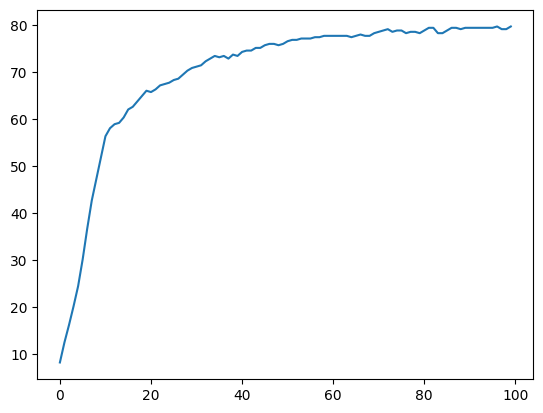

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-4
dataset = 'SoyBean'
prefix = 'ResNet50-Adam-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# treina o modelo
net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id:  57
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
7
Predicted: southern_blight | Corrected: southern_blight | Confidence: 82.93%


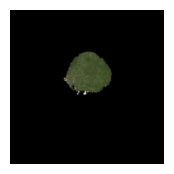

In [ ]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "bacterial_blight", "brown_spot", "crestamento", "ferrugem", "mossaic_virus", "powdery_mildew",
        "septoria", "southern_blight", "sudden_death_syndrone", "yellow_mosaic"
    ]


    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
sample_and_predict(net)
